In [89]:
import os
import pandas as pd

from QEDV_lib import QuantumError

# Base folder containing the numbered subfolders
base_folder = ""

# List to store dataframes
dfs = []

# Loop through folders 1-10
for i in range(11, 16):
    folder_path = os.path.join(base_folder, str(i))
    
    # Check if folder exists
    if os.path.isdir(folder_path):
        # Loop through all .pkl files in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".pkl"):
                file_path = os.path.join(folder_path, file)
                df = pd.read_pickle(file_path)  # Read the pickle file
                dfs.append(df)

# Concatenate all dataframes
if dfs:
    final_df = pd.concat(dfs, ignore_index=True)
    print(final_df)
else:
    print("No pickle files found.")

      Error Rate  Dimension  Solvable    rlimit      time  Brute  BruteTime  \
0          0.001          3      True       258  0.003522  False          0   
1          0.001          3      True       516  0.001228  False          0   
2          0.001          3      True       774  0.001191  False          0   
3          0.001          3      True      1032  0.001556  False          0   
4          0.001          3      True      1290  0.001298  False          0   
...          ...        ...       ...       ...       ...    ...        ...   
5395       0.500         49     False  18032763  0.555945  False          0   
5396       0.500         49     False  18068385  0.558137  False          0   
5397       0.500         49     False  18104007  0.558903  False          0   
5398       0.500         49     False  18139629  0.550807  False          0   
5399       0.500         49     False  18175251  0.574477  False          0   

                                            trials_

In [105]:
df = final_df

In [114]:
# Extract number of qubits from the trials_test object
df["num_qubits"] = df["trials_test"].apply(lambda x: len(x.qubits) if hasattr(x, "qubits") else None)

# Compute correlation between num_qubits and time
correlation = df["num_qubits"].corr(df["time"])
print("Correlation between number of errors and time:", correlation)


Correlation between number of errors and time: 0.604402953702332


In [115]:
df.groupby("Error Rate")['time'].mean()

Error Rate
0.001    0.176660
0.010    0.173595
0.050    0.173370
0.100    0.171237
0.200    0.171296
0.250    0.171322
0.300    0.171004
0.350    0.170654
0.500    0.170337
Name: time, dtype: float64

In [108]:
import numpy as np
def calcDifficulty(error, len):
    matrix = np.zeros((len,len))
    for qubit in error.qubits:
        row = qubit % len
        col = qubit // len
        matrix[row][col] = 1
    n = len
    
    if n == 0: return []
    
    # Directions for up, down, left, right, and diagonals
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),   # Up, Down, Left, Right
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]  # Diagonals
    
    visited = [[False] * n for _ in range(n)]
    chains = []  # To store the lengths of all chains

    def dfs(x, y):
        stack = [(x, y)]
        visited[x][y] = True
        length = 1  # Count the initial 1
        
        while stack:
            cx, cy = stack.pop()
            for dx, dy in directions:
                nx, ny = cx + dx, cy + dy
                # Check if the neighbor is within bounds and a 1 that hasn't been visited
                if 0 <= nx < n and 0 <= ny < n and not visited[nx][ny] and matrix[nx][ny] == 1:
                    visited[nx][ny] = True
                    stack.append((nx, ny))
                    length += 1
        return length

    # Traverse all cells in the matrix
    for i in range(n):
        for j in range(n):
            if matrix[i][j] == 1 and not visited[i][j]:
                # Run DFS to find the chain length
                chain_length = dfs(i, j)
                chains.append(chain_length)

    return chains

In [109]:
from QEDV_lib import QuantumError
matrix = [
    [1, 0, 1, 1],
    [1, 1, 0, 0],
    [0, 1, 1, 1],
    [0, 0, 1, 1]
]

calcDifficulty(QuantumError({1,2,8}),3)  # Output: 5 (longest connected chain of 1’s)


[2, 1]

In [116]:

def getDiff(trial_test, trial_dim):
    # Example implementation (adjust based on your actual function)
    lis = calcDifficulty(trial_test, trial_dim)
    sum = 0
    for entry in lis:
        sum += entry**2
    return sum

def maxLength(trials_test, trials_dim):
    result = calcDifficulty(trials_test, trials_dim)
    if result:
        return max(result)
    return 0
# Create a new list to store the getDiff values
df['diff'] = df.apply(lambda row: getDiff(row['trials_test'], row['trial_dim']), axis=1)

df['diff_2'] = df.apply(lambda row: maxLength(row['trials_test'], row['trial_dim']), axis=1)



In [111]:
correlation = df['diff'].corr(df['time'])
correlation2 = df['diff_2'].corr(df['time'])

print("With length of chain squared", correlation, "With max length", correlation2)

With length of chain squared 0.27612485747272003 With max length 0.2701542045923505


In [112]:
df['trial_dim'].unique()


array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49])

In [133]:
df.groupby('trial_dim')[['time','num_qubits']].corr().unstack().iloc[:,1]


trial_dim
3    -0.246411
5    -0.554794
7    -0.435265
9    -0.449922
11   -0.473867
13   -0.255049
15   -0.379987
17   -0.020824
19   -0.374627
21   -0.318439
23   -0.068387
25   -0.259557
27   -0.144557
29   -0.064754
31   -0.481777
33   -0.374628
35   -0.136470
37   -0.270954
39   -0.287655
41   -0.241846
43   -0.281406
45   -0.307544
47   -0.276887
49   -0.355661
Name: (time, num_qubits), dtype: float64

In [118]:
# Compute overall correlation (without grouping)
overall_corr_diff = df["diff"].corr(df["time"])
overall_corr_diff2 = df["diff_2"].corr(df["time"])
overall_corr_qubits = df["num_qubits"].corr(df["time"])

print("Overall Correlation:")
print("diff vs. time:", overall_corr_diff)
print("diff_2 vs. time:", overall_corr_diff2)
print("num_qubits vs. time:", overall_corr_qubits)


Overall Correlation:
diff vs. time: 0.27612485747272003
diff_2 vs. time: 0.2701542045923505
num_qubits vs. time: 0.604402953702332


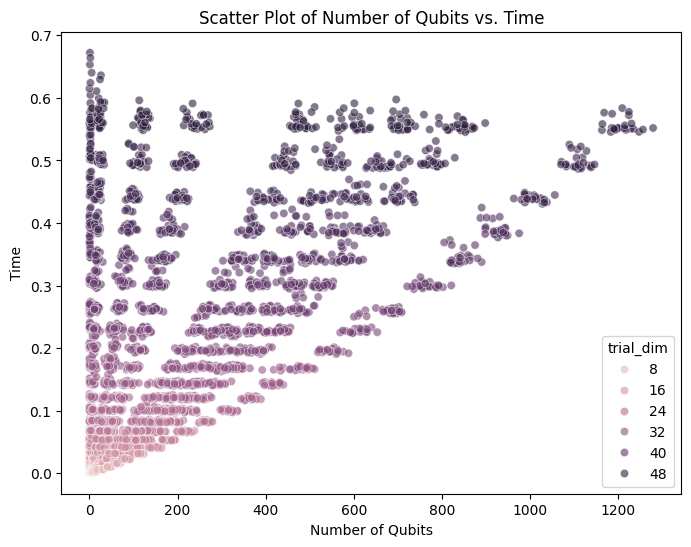

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["num_qubits"], y=df["time"], hue=df["trial_dim"], alpha=0.6)

# Add labels and title
plt.xlabel("Number of Qubits")
plt.ylabel("Time")
plt.title("Scatter Plot of Number of Qubits vs. Time")

# Show the plot
plt.show()


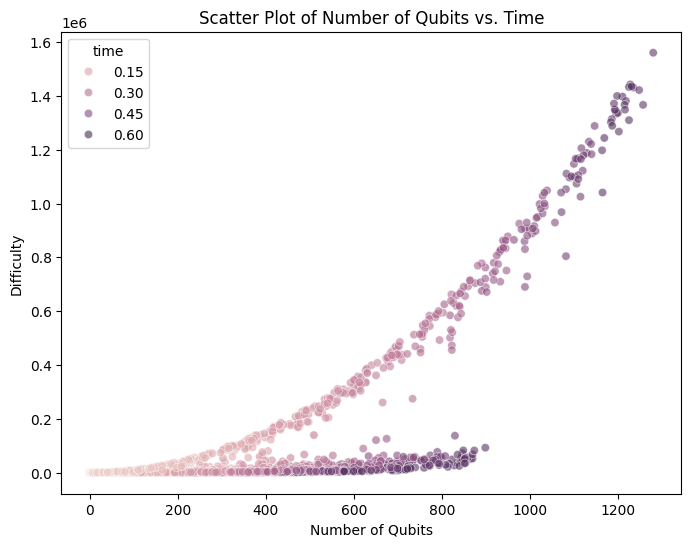

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["num_qubits"], y=df["diff"], hue=df["time"], alpha=0.6)

# Add labels and title
plt.xlabel("Number of Qubits")
plt.ylabel("Difficulty")
plt.title("Scatter Plot of Number of Qubits vs. Time")

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["num_qubits"], y=df["diff"], hue=df["trial_dim"], alpha=0.6)

# Add labels and title
plt.xlabel("Number of Qubits")
plt.ylabel("Difficulty")
plt.title("Scatter Plot of Number of Qubits vs. Time")

# Show the plot
plt.show()
